In [16]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
metadata = pd.read_csv("../HAM10000_metadata.csv")
metadata.describe(include="all")

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0000835,ISIC_0032462,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [4]:
print(metadata.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [5]:
labels = list(metadata.dx.unique())
print(labels)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


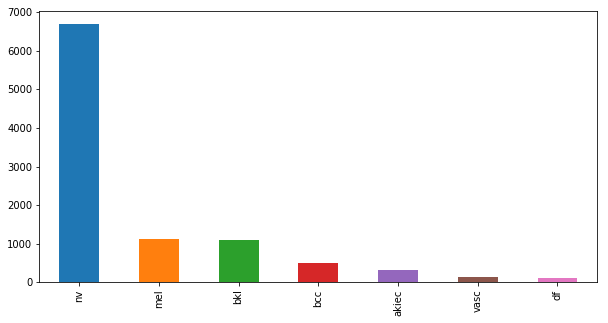

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
counts = metadata["dx"].value_counts()
print(counts)
counts.plot(kind='bar', ax=ax1)
#metadata["dx"].hist()

In [7]:
threshold = 2000

# parse out all classes to individual dataframes
nv = metadata[metadata["dx"] == "nv"]
nv = nv.sample(n=threshold)
nv.name = "nv"
mel = metadata[metadata["dx"] == "mel"]
mel.name = "mel"
bkl = metadata[metadata["dx"] == "bkl"]
bkl.name = "bkl"
bcc = metadata[metadata["dx"] == "bcc"]
bcc.name = "bcc"
akiec = metadata[metadata["dx"] == "akiec"]
akiec.name = "akiec"
vasc = metadata[metadata["dx"] == "vasc"]
vasc.name = "vasc"
df = metadata[metadata["dx"] == "df"]
df.name = "df"
# list out
classes = [nv, mel, bkl, bcc, akiec, vasc, df]

In [8]:
# preprocess accordingly
def preprocess(_image):
    #_image = cv2.cvtColor(_image, cv2.COLOR_BGR2RGB)
    
    #_image = cv2.equalizeHist(_image) 
    #_image = cv2.GaussianBlur(_image, (3,3), 1)
    _image = cv2.cvtColor(_image, cv2.COLOR_RGB2HSV)
    H,S,V = cv2.split(_image)
    _V = cv2.equalizeHist(V) 
    _image = cv2.merge([H, S, _V])
    _image = cv2.cvtColor(_image, cv2.COLOR_HSV2RGB)
    
    return _image

## Seperate into Respective Folders

In [10]:
import shutil
from sklearn.model_selection import train_test_split

#threshold = 2000
# seperate images to each directory 
os.mkdir("ham_labled")
os.mkdir("ham_labled/train")
os.mkdir("ham_labled/test")

# each class
for _class in classes:
    _train, _test = train_test_split(_class, test_size = 0.2)
    print("Training: {}, Test: {} images found for class {}".format(len(_train), len(_test), _class.name))
    # train 
    os.mkdir("ham_labled/train/{}".format(_class.name))
    for i, row in _train.iterrows():
        image_id = row["image_id"]
        img = cv2.imread("../ham10000/{}.jpg".format(image_id))
        img = cv2.resize(img, (224, 224))
        cv2.imwrite("../ham10000/{}.jpg".format(image_id), img)
        shutil.move(
            src="../ham10000/{}.jpg".format(image_id), 
            dst="ham_labled/train/{}/".format(_class.name)
        )
    # test
    os.mkdir("ham_labled/test/{}".format(_class.name))
    for i, row in _test.iterrows():
        image_id = row["image_id"]
        img = cv2.imread("../ham10000/{}.jpg".format(image_id))
        img = cv2.resize(img, (224, 224))
        cv2.imwrite("../ham10000/{}.jpg".format(image_id), img)
        shutil.move(
            src="../ham10000/{}.jpg".format(image_id), 
            dst="ham_labled/test/{}/".format(_class.name)
        )
    print("Moving complete for class {}...".format(_class.name))

Training: 1600, Test: 400 images found for class nv
Moving complete for class nv...
Training: 890, Test: 223 images found for class mel
Moving complete for class mel...
Training: 879, Test: 220 images found for class bkl
Moving complete for class bkl...
Training: 411, Test: 103 images found for class bcc
Moving complete for class bcc...
Training: 261, Test: 66 images found for class akiec
Moving complete for class akiec...
Training: 113, Test: 29 images found for class vasc
Moving complete for class vasc...
Training: 92, Test: 23 images found for class df
Moving complete for class df...


## Image Augumentation

Before we can start passing above images through a CNN feature extractor, we will augument images to address class imbalance problem and set a threshold of 5000 images per class.

In [11]:
from keras.preprocessing.image import ImageDataGenerator

_generator = ImageDataGenerator(
    width_shift_range=0.001,
    height_shift_range=0.001,
    zoom_range=0.01,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.99
)

Using TensorFlow backend.


In [12]:
from keras.preprocessing.image import img_to_array

def load_images(directory):
    images = [cv2.cvtColor(cv2.imread(os.path.join(directory, file)), cv2.COLOR_BGR2RGB)
              for file in os.listdir(directory)]
    images = [img_to_array(image, data_format="channels_last") for image in images]
    images = np.array(images)
    images = images.astype("float")
    return images
    

In [13]:
batch = 32
for _class in classes:
    _name = _class.name
    if len(_class) >= threshold:
        continue
    else:
        # what a pain ....PHEW!
        if os.path.exists("ham_labled/train/{}/.ipynb_checkpoints/".format(_name)):
            shutil.rmtree("ham_labled/train/{}/.ipynb_checkpoints/".format(_name))
        print("Augumenting images for class {}...".format(_name))
        X = load_images("ham_labled/train/{}/".format(_name))
        _auguments = _generator.flow(
            x=X,
            y=None,
            batch_size=batch,
            save_format="jpg",
            save_prefix="augumented",
            save_to_dir="ham_labled/train/{}/".format(_name)
        )
        for _ in range(int(np.ceil((threshold - X.shape[0])/batch))):
            x = next(_auguments)

Augumenting images for class mel...
Augumenting images for class bkl...
Augumenting images for class bcc...
Augumenting images for class akiec...
Augumenting images for class vasc...
Augumenting images for class df...


## Read the newly generated Images and process them accordingly

In [12]:
try:
    from imutils import paths
except ModuleNotFoundError:
    !pip install imutils
    from imutils import paths
import random
import os
from sklearn.preprocessing import LabelEncoder

image_paths = list(paths.list_images("ham_labled/train"))
random.shuffle(image_paths)

labels = [cls.split(os.path.sep)[-2] for cls in image_paths]
le = LabelEncoder()
labels = le.fit_transform(labels)

print("{} total images found...".format(len(image_paths)))


  Running setup.py bdist_wheel for imutils ... done
  Stored in directory: /root/.cache/pip/wheels/b2/40/59/139d450e68847ef2f27d876d527b13389dac23df0f66526b5d
Successfully built imutils
scikit-umfpack 0.3.2 has requirement numpy>=1.15.3, but you'll have numpy 1.15.1 which is incompatible.
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 2.2.3 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.2.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.1.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
13190 total images found...


## Model

In [29]:
import tensorflow as tf
from keras import backend as K
from keras import callbacks
from keras.models import Sequential, Model
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.applications import ResNet50

In [30]:
class CustomNet(object):

    def __init__(self, height, width, channels, classes, parameter_scaling):
        self.height = height
        self.width = width
        self.channels = channels
        self.output_classes = classes
        self.scale = parameter_scaling
        
    """   
    def model(self):
        _model = ResNet50(
            weights="imagenet",
            include_top=False,
            input_shape=(self.height, self.width, self.channels)
        )
        x = _model.output
        x = Dropout(0.75)(x)
        x = Flatten()(x)
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.75)(x)
        x = Dense(self.output_classes, activation="softmax")(x)
        model = Model(inputs=_model.input, outputs=x)
        return model
        
    """  
    def model(self):
        
        input_shape = (self.height, self.width, self.channels)
        axis = -1
        # if using theano
        if K.image_data_format() == "channels_first":
            input_shape = (self.channels, self.height, self.width)
            axis = 1
        # initiate model
        _model = Sequential()
        
        # conv_1
        _model.add(Conv2D(
            12, (3, 3),
            padding="same",
            input_shape=input_shape)
        )
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        
        # Fully connected layers
        _model.add(Flatten())
        _model.add(Dropout(0.5))
        # classifier
        _model.add(Dense(self.output_classes))
        _model.add(Activation("softmax"))

        # return model
        return _model


In [31]:
import multiprocessing
manager = multiprocessing.Manager()
queue = manager.Queue(maxsize=10)

BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 1
PARAMETER_SCALING = 16
IM_WIDTH = 224
IM_HEIGHT = 224

def lr_scheduler(epoch, lr):
    adjusted_lr = 1e-5 if epoch >= 10 else lr
    print("Current Learning Rate: {}, Adjusted Learning Rate: {}".format(
        str(lr), str(adjusted_lr)
    ))
    return adjusted_lr

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def train():
    
        h_callbacks = [
            callbacks.TensorBoard(
                log_dir="tensorboard",
                write_graph=True,
                write_images=False
            ),
            LearningRateScheduler(lr_scheduler)
        ]
        _model = CustomNet(
            height=IM_HEIGHT,
            width=IM_WIDTH,
            channels=3,
            classes=7,
            parameter_scaling=PARAMETER_SCALING
        ).model()
        _model.compile(
            loss="categorical_crossentropy",
            optimizer=Adam(lr=LR),
            metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy]
        )
        
        # generators made according to the post
        # https://github.com/keras-team/keras/issues/5862
        data_generator = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )
        train_generator = data_generator.flow_from_directory(
            directory="ham_labled/train",
            target_size=(IM_WIDTH, IM_HEIGHT),
            shuffle=True,
            color_mode="rgb",
            class_mode="categorical",
            batch_size=BATCH_SIZE,
            subset="training"
        )
        valid_generator = data_generator.flow_from_directory(
            directory="ham_labled/train",
            target_size=(IM_WIDTH, IM_HEIGHT),
            shuffle=True,
            color_mode="rgb",
            class_mode="categorical",
            batch_size=BATCH_SIZE,
            subset="validation"
        )
        # train
        history = _model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            validation_data=valid_generator,
            validation_steps=valid_generator.samples//valid_generator.batch_size,
            callbacks=h_callbacks,
            epochs=EPOCHS
        )
        return _model, history

In [ ]:
model_ret, history_ret = train()

Found 10556 images belonging to 7 classes.
Found 2634 images belonging to 7 classes.
Epoch 1/1
Current Learning Rate: 9.999999747378752e-05, Adjusted Learning Rate: 9.999999747378752e-05
 23/164 [===>..........................] - ETA: 12:40 - loss: 3.4499 - categorical_accuracy: 0.3193 - top_2_accuracy: 0.5156 - top_3_accuracy: 0.6467

In [13]:
## PREDICTION
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array, load_img
from imutils import paths
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [27]:
# method-1
def load_test_data(directory):
    data = []
    labels = []
    image_paths = list(paths.list_images(directory))
    for i, image_path in enumerate(image_paths):
        # read
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        # keras format
        image = img_to_array(image, data_format="channels_last")
        label = image_path.split(os.path.sep)[-2]
        # append
        data.append(image)
        labels.append(label)
    # conversions
    data = np.array(data)
    data = data.astype("float")
    return data, np.array(labels)

# easy generator method
data_generator = ImageDataGenerator(rescale=1./255)

test_generator = data_generator.flow_from_directory(
    directory="ham_labled/test/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1
)
print(test_generator.class_indices)

Found 1064 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [26]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc = model_ret.evaluate_generator(test_generator, steps=test_generator.samples)

print('val_loss:', test_loss)
print('val_cat_acc:', test_cat_acc)
print('val_top_2_acc:', test_top_2_acc)
print('val_top_3_acc:', test_top_3_acc)

(1064, 224, 224, 3)
(1064,)
akiec


In [28]:
# PREDICT
predictions = model_ret.predict_generator(test_generator, steps=test_generator.samples, verbose=1)
print(predictions.shape)
y_pred = np.argmax(predictions, axis=1)
y_test = test_generator.classes

(1064, 7)


In [20]:
report = classification_report(y_test, y_pred, target_names=[k.key for k in test_generator.class_indices])
print(report)

1064/1064 [==============================] - 31s 29ms/step
(1064, 7)


In [23]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [24]:
im_paths = list(paths.list_images("ham_labled/test"))
class_names = [imp.split(os.path.sep)[-2] for imp in im_paths]
class_names = [str(x) for x in np.unique(class_names)]

report = classification_report(
    y_test.argmax(axis=1),
    y_pred.argmax(axis=1),
    target_names=class_names
)

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
print(report)

             precision    recall  f1-score   support

      akiec       0.00      0.00      0.00        66
        bcc       0.00      0.00      0.00       103
        bkl       0.00      0.00      0.00       220
         df       0.00      0.00      0.00        23
        mel       0.50      0.02      0.03       223
         nv       0.00      0.00      0.00       400
       vasc       0.03      1.00      0.05        29

avg / total       0.11      0.03      0.01      1064



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the loss
plt.plot(history.history_ret['loss'])
plt.plot(history.history_ret['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()